# Recurrent Neural Networks
RRNs are often used when dealing with sequences of variable lenght, like time-series. The goal, generally, is to predict the future behaviour of the series.

In [35]:
import numpy as np
import tensorflow as tf
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, SimpleRNN, TimeDistributed

In [2]:
rndm_seed = 542
np.random.seed(rndm_seed)
tf.random.set_seed(rndm_seed)

## What does it mean for a network to be recurrent?
While in a traditional feedforward neural network the signal only flows in one direction, from the input to the output, recurrent networks have loops where the signal is going backward. At each step in time (t) a recurrent neuron will receive not only its current inputs ($x_t$), but also its own output at the previous timestep ($y_{t-1}$). Thus, each recurrent neurons will have (at least) two sets of weights, one for the current input ($w_x$) and one for the previous output ($w_y$). Since recurrent neurons and layers hold past information, or at least some of it, they are often referred to as memory cells. 
RNNs are classified according to their types of inputs and outputs:
* Sequence-to-sequence networks take a sequence of inputs (e.g. stock prices over last N days) and return the same sequence shifted in the future (e.g. stock prices from N-1 days to tomorrow).
* Sequence-to-vector networks take a sequence of inputs and return only the last output (e.g. stock price tomorrow, sentiment score, ...).
* Vector-to-sequence networks take a single input (e.g. an image) and return a sequence (e.g. a caption for that image)
* Encoder-Decoder networks are composed of a sequence-to-vector encoder followed by a vector-to-sequence decoder. This works better than a simple sequence-to-sequence network in certain scenarios.

## Data
Recurrent networks take a sequence of one or more values per timestep as their input. This sequences are most often time series, which can either be univariate or multivariate. The most common task is forecasting, however, also imputation of missing past values is possible.

Let's generate synthetic time-series:

In [3]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offset1, offset2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time-offset1) * (freq1 * 10 + 10))
    series += 0.2 * np.sin((time-offset2) * (freq2 * 20 + 20))
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)
    return series[..., np.newaxis].astype(np.float32)

And define a nice function for drawing time-series plots:

In [25]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

Generate 3 synthetic time series, each 100 timesteps long. 

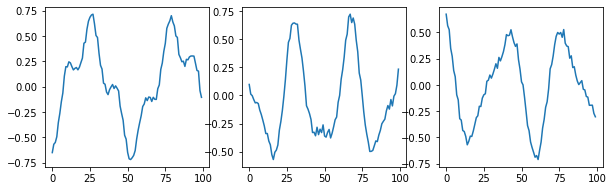

In [4]:
x = generate_time_series(3, 100)

plt.figure(figsize=(10,10))
for i in range(3):
    plt.subplot(3,3,i+1)
    plt.plot(range(100), x[i,:,0])
plt.show()

Create a training, validation and test set.

In [27]:
n_steps = 50
series = generate_time_series(10000, n_steps+1)
x_train, y_train = series[:7000, :n_steps], series[:7000, -1]
x_val, y_val = series[7000:9000, :n_steps], series[7000:9000, -1]
x_test, y_test = series[9000:, :n_steps], series[9000:, -1]

print(f'Train X shape: {x_train.shape}')
print(f'Train Y shape: {y_train.shape}')

Train X shape: (7000, 50, 1)
Train Y shape: (7000, 1)


And make a nice plot using the custom function:

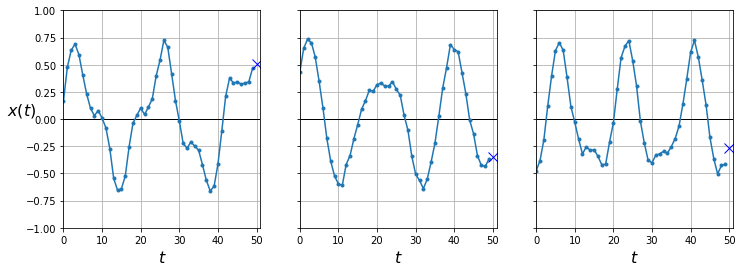

In [28]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(x_val[col, :, 0], y_val[col, 0],
                y_label=("$x(t)$" if col==0 else None))
plt.show()

## Baselines
It is always nice to have to have some simple baselines against which to compare results from more complex models. The easiest possibility is to predict that the future value will be equal to last observed values in the series.  Alternatively, we could use a simple linear regression.

Naive prediction MSE: 0.020155971869826317


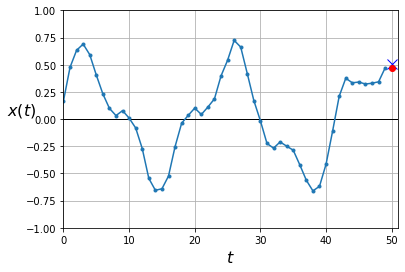

In [38]:
# 1) always predict last observed value
y_pred = x_val[:,-1]
mse = np.mean(mean_squared_error(y_val, y_pred))
print(f'Naive prediction MSE: {mse}')

# make a plot
plot_series(x_val[0, :, 0], y_val[0, 0], y_pred[0, 0])
plt.show()

In [39]:
np.random.seed(rndm_seed)
tf.random.set_seed(rndm_seed)

# 2) linear regression
model = Sequential([
        Flatten(input_shape = [n_steps, 1]),
        Dense(1)])
model.compile(loss = mean_squared_error, optimizer = 'nadam')
print('\n \n *** Training linear model: *** \n')
history = model.fit(x_train, y_train, epochs = 20, 
          validation_data = (x_val, y_val))

y_pred = model.predict(x_val)
mse = np.mean(mean_squared_error(y_val, y_pred))
print(f'\n Linear model MSE: {mse}')


 
 *** Training linear model: *** 

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 1s 112us/sample - loss: 0.1126 - val_loss: 0.0311
Epoch 2/20
7000/7000 [==============================] - 0s 61us/sample - loss: 0.0221 - val_loss: 0.0173
Epoch 3/20
7000/7000 [==============================] - 0s 61us/sample - loss: 0.0145 - val_loss: 0.0133
Epoch 4/20
7000/7000 [==============================] - 0s 56us/sample - loss: 0.0117 - val_loss: 0.0114
Epoch 5/20
7000/7000 [==============================] - 0s 58us/sample - loss: 0.0101 - val_loss: 0.0098
Epoch 6/20
7000/7000 [==============================] - 0s 61us/sample - loss: 0.0089 - val_loss: 0.0087
Epoch 7/20
7000/7000 [==============================] - 0s 57us/sample - loss: 0.0079 - val_loss: 0.0078
Epoch 8/20
7000/7000 [==============================] - 0s 57us/sample - loss: 0.0071 - val_loss: 0.0069
Epoch 9/20
7000/7000 [==============================] - 0s 57us/sample - l

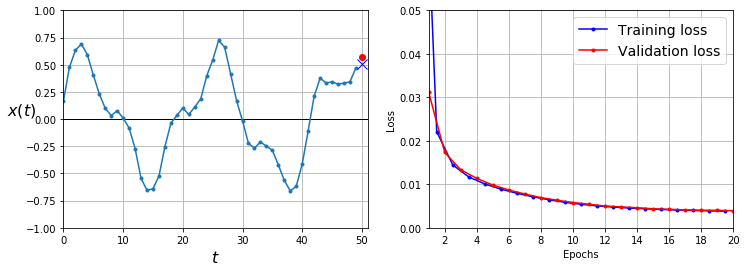

In [40]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

    
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

plt.sca(axes[0])
plot_series(x_val[0, :, 0], y_val[0, 0], y_pred[0, 0])

plt.sca(axes[1])
plot_learning_curves(history.history["loss"], history.history["val_loss"])

plt.show()

## Simple RNN (seq-to-vect)
Let's begin with a very simple recurrent network that only has one hidden layer with one recurrent neuron. Notice that there is no need to fix the lenght of the series as we did with linear regression, instead, we can simply pass 'None' as the first dimension. Performances are worse than linear regression, most likely because the number of parameters is much lower!

In [43]:
np.random.seed(rndm_seed)
tf.random.set_seed(rndm_seed)

# Simple RNN (1 layer, 1 unit)
model = Sequential([
        SimpleRNN(1, input_shape = [None, 1])])
model.compile(loss = mean_squared_error, optimizer = 'nadam')

print('\n \n *** Training simpleRNN model: *** \n')
history = model.fit(x_train, y_train, epochs = 20, validation_data = (x_val, y_val))

y_pred = model.predict(x_val)
mse = np.mean(mean_squared_error(y_val, y_pred))
print(f'\n Simple RNN MSE: {mse}')


 
 *** Training simpleRNN model: *** 

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 3s 479us/sample - loss: 0.1948 - val_loss: 0.1766
Epoch 2/20
7000/7000 [==============================] - 2s 307us/sample - loss: 0.1621 - val_loss: 0.1482
Epoch 3/20
7000/7000 [==============================] - 2s 312us/sample - loss: 0.1367 - val_loss: 0.1249
Epoch 4/20
7000/7000 [==============================] - 2s 295us/sample - loss: 0.1134 - val_loss: 0.1014
Epoch 5/20
7000/7000 [==============================] - 2s 308us/sample - loss: 0.0912 - val_loss: 0.0805
Epoch 6/20
7000/7000 [==============================] - 2s 309us/sample - loss: 0.0718 - val_loss: 0.0624
Epoch 7/20
7000/7000 [==============================] - 2s 326us/sample - loss: 0.0550 - val_loss: 0.0469
Epoch 8/20
7000/7000 [==============================] - 2s 323us/sample - loss: 0.0409 - val_loss: 0.0342
Epoch 9/20
7000/7000 [==============================] - 2s 309us

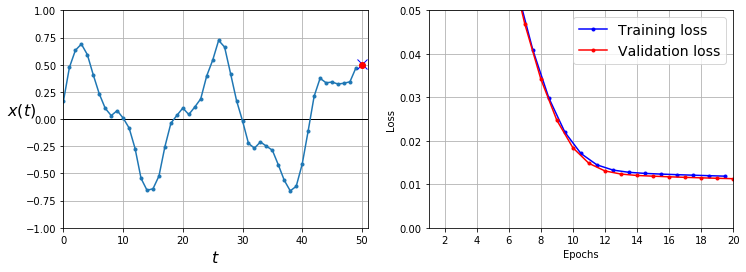

In [44]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

plt.sca(axes[0])
plot_series(x_val[0, :, 0], y_val[0, 0], y_pred[0, 0])

plt.sca(axes[1])
plot_learning_curves(history.history["loss"], history.history["val_loss"])

plt.show()

**Stacking multiple recurrent layers** is simple and can improve performances in a important way. Notice that the argument 'return_sequences' should be set to true for all recurrent layers that are followed by another recurrent layer. Furthermore, as with CNNs, the last layer is usually dense.

In [45]:
np.random.seed(rndm_seed)
tf.random.set_seed(rndm_seed)

model = Sequential([
        SimpleRNN(20, return_sequences = True, input_shape = [None, 1]),
        SimpleRNN(20),
        Dense(1)])
model.compile(loss = mean_squared_error, optimizer = 'nadam')

print('\n \n *** Training DeepRNN model: *** \n')
model.fit(x_train, y_train, epochs = 20, 
          validation_data = (x_val, y_val))

y_pred = model.predict(x_val)
mse = np.mean(mean_squared_error(y_val, y_pred))
print(f'Deep RNN MSE: {mse}')


 
 *** Training DeepRNN model: *** 

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.0211 - val_loss: 0.0063
Epoch 2/20
7000/7000 [==============================] - 5s 749us/sample - loss: 0.0047 - val_loss: 0.0041
Epoch 3/20
7000/7000 [==============================] - 5s 780us/sample - loss: 0.0035 - val_loss: 0.0032
Epoch 4/20
7000/7000 [==============================] - 5s 734us/sample - loss: 0.0031 - val_loss: 0.0032
Epoch 5/20
7000/7000 [==============================] - 6s 907us/sample - loss: 0.0029 - val_loss: 0.0029
Epoch 6/20
7000/7000 [==============================] - 5s 771us/sample - loss: 0.0029 - val_loss: 0.0028
Epoch 7/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.0028 - val_loss: 0.0028
Epoch 8/20
7000/7000 [==============================] - 6s 916us/sample - loss: 0.0028 - val_loss: 0.0031
Epoch 9/20
7000/7000 [==============================] - 5s 732us/sampl

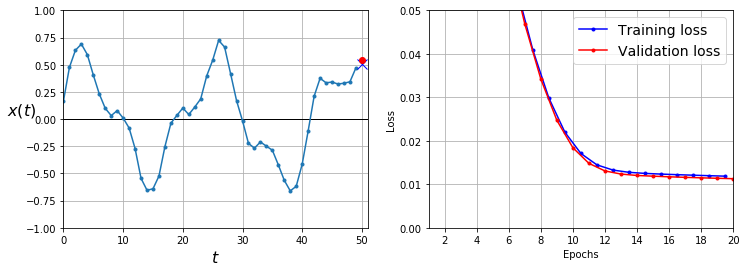

In [46]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

plt.sca(axes[0])
plot_series(x_val[0, :, 0], y_val[0, 0], y_pred[0, 0])

plt.sca(axes[1])
plot_learning_curves(history.history["loss"], history.history["val_loss"])

plt.show()

### Making predictions deeper in time
Rather than predicting only the value of $y$ tomorrow, we may want to make a prediction several steps ahead (e.g. next 10 values).  One naive possibility is to train the network, make a prediction, add it to the inputs, make a new prediction and so.

In [47]:
np.random.seed(rndm_seed+342)

series2 = generate_time_series(1, n_steps + 10)
x_new, y_new = series2[:, :n_steps], series2[:, n_steps:]

x = x_new
for step in range(10):
    y_pred_one = model.predict(x[:, step:])[:, np.newaxis, :]
    x = np.concatenate([x, y_pred_one], axis=1)
    
y_pred = x[:, n_steps:]
print(f'Predictions shape: {y_pred.shape}')

mse = np.mean(mean_squared_error(y_new, y_pred))
print(f'Predictions MSE: {mse}')

Predictions shape: (1, 10, 1)
Predictions MSE: 0.015743890777230263


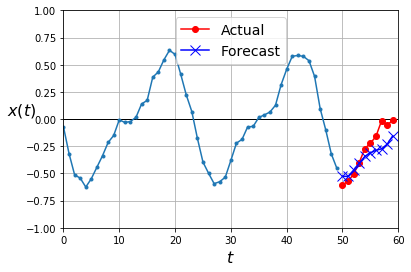

In [48]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "ro-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "bx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

plot_multiple_forecasts(x_new, y_new, y_pred)
plt.show()

Another possibility is to directly train the network to predict several timesteps ahead. In order to do this, we have to redefine the training, validation and test sets. 

In [49]:
np.random.seed(rndm_seed)
n_steps = 50

series = generate_time_series(10000, n_steps+10)
x_train, y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
x_val, y_val = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
x_test, y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

Try again to make predictions one by one.

In [50]:
x = x_val
for step_ahead in range(10):
    y_pred_one = model.predict(x)[:, np.newaxis, :]
    x = np.concatenate([x, y_pred_one], axis=1)

y_pred = x[:, n_steps:, 0]
print(f'Predictions shape: {y_pred.shape}')

mse = np.mean(mean_squared_error(y_val, y_pred))
print(f'Predictions MSE: {mse}')

Predictions shape: (2000, 10)
Predictions MSE: 0.021858692169189453


Naive-prediction (equal to last observed value):

In [51]:
Y_naive_pred = y_val[:, -1:]
mse = np.mean(mean_squared_error(y_val, Y_naive_pred))
print(f'Predictions MSE: {mse}')

Predictions MSE: 0.21207420527935028


Finally, let's make a RNN that predicts all the 10 future values at once:

In [52]:
np.random.seed(rndm_seed)
tf.random.set_seed(rndm_seed)

model = Sequential([
        SimpleRNN(20, return_sequences = True, input_shape = [None, 1]),
        SimpleRNN(20),
        Dense(10)])
model.compile(loss = 'mse', optimizer = 'nadam')

print('\n \n *** Training 10 steps-ahead DeepRNN model: *** \n')
history = model.fit(x_train, y_train, epochs = 20, 
          validation_data = (x_val, y_val))


 
 *** Training 10 steps-ahead DeepRNN model: *** 

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.0622 - val_loss: 0.0328
Epoch 2/20
7000/7000 [==============================] - 5s 786us/sample - loss: 0.0248 - val_loss: 0.0256
Epoch 3/20
7000/7000 [==============================] - 5s 697us/sample - loss: 0.0176 - val_loss: 0.0151
Epoch 4/20
7000/7000 [==============================] - 5s 687us/sample - loss: 0.0146 - val_loss: 0.0137
Epoch 5/20
7000/7000 [==============================] - 5s 682us/sample - loss: 0.0131 - val_loss: 0.0124
Epoch 6/20
7000/7000 [==============================] - 5s 686us/sample - loss: 0.0119 - val_loss: 0.0127
Epoch 7/20
7000/7000 [==============================] - 5s 678us/sample - loss: 0.0114 - val_loss: 0.0108
Epoch 8/20
7000/7000 [==============================] - 5s 719us/sample - loss: 0.0107 - val_loss: 0.0105
Epoch 9/20
7000/7000 [==============================]

In [55]:
np.random.seed(rndm_seed+342)

series2 = generate_time_series(1, n_steps + 10)
x_new, y_new = series2[:, :n_steps, :], series2[:, n_steps:, :]

y_pred = model.predict(x_new)[..., np.newaxis]
print(f'Predictions shape: {y_pred.shape}')

mse = np.mean(mean_squared_error(y_new, y_pred))
print(f'Predictions MSE: {mse}')

Predictions shape: (1, 10, 1)
Predictions MSE: 0.004085707012563944


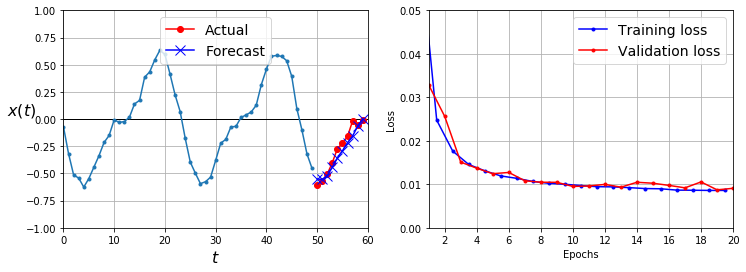

In [56]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

plt.sca(axes[0])
plot_multiple_forecasts(x_new, y_new, y_pred)

plt.sca(axes[1])
plot_learning_curves(history.history["loss"], history.history["val_loss"])

plt.show()

## Simple RNN (seq-to-seq)
A sequence to sequence network will output a vector of forecasts at each timestep (e.g. at step 0, forecast from 1 to 10, at step 1 forecast from 2 to 11, and so on). Each target must be a sequence of same lenght as the input sequence. 

In [57]:
y = np.empty((10000, n_steps, 10))
for step in range(1, 10+1):
    y[:, :, step-1] = series[:, step:step + n_steps, 0]
    
y_train = y[:7000]
y_val = y[7000:9000]
y_test = y[9000:]

Define and train the sequence-to-sequence network:

In [58]:
np.random.seed(rndm_seed)
tf.random.set_seed(rndm_seed)

model = Sequential([
        SimpleRNN(20, return_sequences = True, input_shape = [None, 1]),
        SimpleRNN(20, return_sequences = True),
        TimeDistributed(Dense(10))
])

def last_time_step_mse(y_true, y_pred):
    return mean_squared_error(y_true[:, -1], y_pred[:, -1])

model.compile(loss = 'mse', optimizer = 'nadam', metrics = [last_time_step_mse])

print('\n \n *** Training seq-to-seq DeepRNN model: *** \n')
history = model.fit(x_train, y_train, epochs = 20, 
          validation_data = (x_val, y_val))


 
 *** Training seq-to-seq DeepRNN model: *** 

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 7s 1ms/sample - loss: 0.0721 - last_time_step_mse: 0.0619 - val_loss: 0.0491 - val_last_time_step_mse: 0.0388
Epoch 2/20
7000/7000 [==============================] - 6s 798us/sample - loss: 0.0441 - last_time_step_mse: 0.0319 - val_loss: 0.0409 - val_last_time_step_mse: 0.0278
Epoch 3/20
7000/7000 [==============================] - 6s 813us/sample - loss: 0.0392 - last_time_step_mse: 0.0259 - val_loss: 0.0379 - val_last_time_step_mse: 0.0255
Epoch 4/20
7000/7000 [==============================] - 5s 745us/sample - loss: 0.0364 - last_time_step_mse: 0.0227 - val_loss: 0.0365 - val_last_time_step_mse: 0.0236
Epoch 5/20
7000/7000 [==============================] - 5s 741us/sample - loss: 0.0345 - last_time_step_mse: 0.0205 - val_loss: 0.0336 - val_last_time_step_mse: 0.0197
Epoch 6/20
7000/7000 [==============================] - 5s 716us/

In [22]:
np.random.seed(rndm_seed+342)

series2 = generate_time_series(1, n_steps + 10)
x_new, y_new = series2[:, :n_steps, :], series2[:, n_steps:, :]

y_pred = model.predict(x_new)[..., np.newaxis]
print(f'Predictions shape: {y_pred.shape}')

mse = np.mean(mean_squared_error(y_new, y_pred))
print(f'Predictions MSE: {mse}')

Predictions shape: (1, 50, 10, 1)
Predictions MSE: 0.26557502150535583


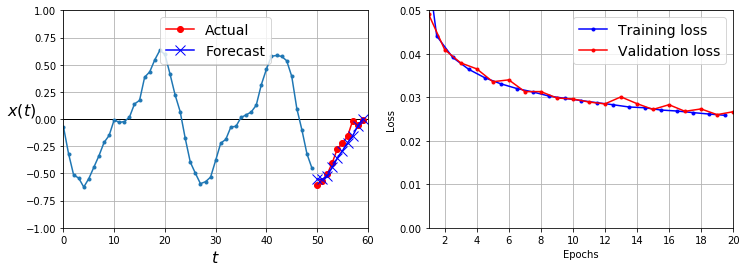

In [59]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

plt.sca(axes[0])
plot_multiple_forecasts(x_new, y_new, y_pred)

plt.sca(axes[1])
plot_learning_curves(history.history["loss"], history.history["val_loss"])

plt.show()